In [1]:
# Deep Learning Fundamentals: MNIST Case Study
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

### Data Collection

In [2]:
import requests

# URLs of the files
data_train_features_url = 'https://www.raphaelcousin.com/modules/module8/exercise/X_train.pth'
data_train_labels_url = 'https://www.raphaelcousin.com/modules/module8/exercise/y_train.pth'
data_test_features_url = 'https://www.raphaelcousin.com/modules/module8/exercise/X_test.pth'
#data_test_labels_url = 'https://www.raphaelcousin.com/modules/module8/exercise/y_test.pth'

# Function to download a file
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# Downloading the files
download_file(data_train_features_url, 'X_train.pth')
download_file(data_train_labels_url, 'y_train.pth')
download_file(data_test_features_url, 'X_test.pth')
#download_file(data_test_labels_url, 'y_test.pth')

Downloaded X_train.pth from https://www.raphaelcousin.com/modules/module8/exercise/X_train.pth
Downloaded y_train.pth from https://www.raphaelcousin.com/modules/module8/exercise/y_train.pth
Downloaded X_test.pth from https://www.raphaelcousin.com/modules/module8/exercise/X_test.pth


In [3]:
# Load the saved tensors
X_train = torch.load('X_train.pth')
y_train = torch.load('y_train.pth')
X_test = torch.load('X_test.pth')
#y_test = torch.load('y_test.pth')

# Print shapes to verify the data
print("Dataset shapes:")
print(f"X_train: {X_train.shape}")  # Should be torch.Size([50000, 3, 32, 32])
print(f"y_train: {y_train.shape}")  # Should be torch.Size([50000])
print(f"X_test: {X_test.shape}")    # Should be torch.Size([10000, 3, 32, 32])
#print(f"y_test: {y_test.shape}")    # Should be torch.Size([10000])

# Example: access the first image and its label
first_image = X_train[0]
first_label = y_train[0]

print(f"\nFirst image shape: {first_image.shape}")  # Should be torch.Size([3, 32, 32])
print(f"First image label: {first_label}")         # Should be a number between 0-9

<ipython-input-3-c61a4efb9fad>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_train = torch.load('X_train.pth')


Dataset shapes:
X_train: torch.Size([50000, 3, 32, 32])
y_train: torch.Size([50000])
X_test: torch.Size([10000, 3, 32, 32])

First image shape: torch.Size([3, 32, 32])
First image label: 6


<ipython-input-3-c61a4efb9fad>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  y_train = torch.load('y_train.pth')
<ipython-input-3-c61a4efb9fad>:4: FutureWarning: You are 

### Data Analysis

In [4]:
X_train.shape

torch.Size([50000, 3, 32, 32])

In [5]:
y_train.shape

torch.Size([50000])

In [6]:
def plot_images(X, y, num_examples=5, figsize=(15, 3)):
    # Create figure
    fig, axes = plt.subplots(1, num_examples, figsize=figsize)

    # Ensure axes is always a numpy array
    if num_examples == 1:
        axes = np.array([axes])

    # Plot each example
    for i in range(num_examples):
        # Get the image
        img = np.array(X[i]).astype(int)

        # If the image has 3 dimensions, transpose it to (height, width, channels)
        if img.ndim == 3 and img.shape[0] == 3:  # Shape is (3, height, width)
            img = np.transpose(img, (1, 2, 0))  # Convert to (height, width, channels)

        # Plot the image
        axes[i].imshow(img)
        axes[i].set_title(f'Label: {y[i]}')
        axes[i].axis('off')

    plt.tight_layout()
    return fig

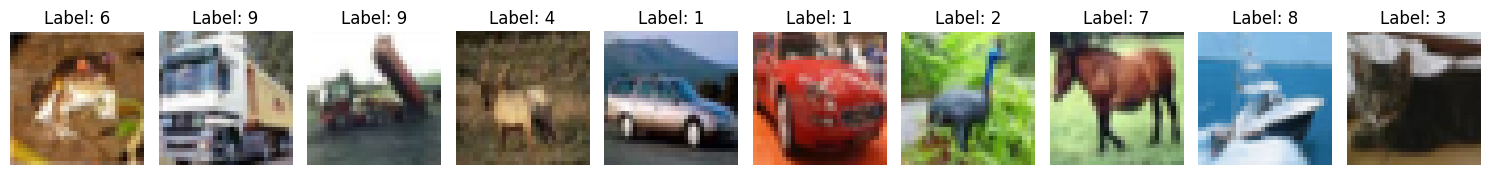

In [7]:
# Plot some examples
fig = plot_images(X_train, y_train, num_examples=10)
plt.show()

### Data Preprocessing
Scale, split the data and create dataLoaders

In [8]:
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [9]:
def preprocess_data(X, y, batch_size=32, train_size=0.7, val_size=0.15, random_state=42):
    # Scale features
    num_samples, nb_layers, height, width = X.shape
    X_reshaped = X.reshape(num_samples, -1)  # Flatten for scaling
    scaler = StandardScaler()
    X_scaled_flat = scaler.fit_transform(X_reshaped)  # Scale features
    X_scaled = X_scaled_flat.reshape(num_samples, nb_layers, height, width)  # Reshape with channel dimension

    # Split data into train+val and test
    test_size = 1 - train_size - val_size
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X_scaled, y, test_size=test_size,
        random_state=random_state, stratify=y
    )

    # Split train+val into train and val
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval,
        test_size=val_size/(train_size + val_size),
        random_state=random_state, stratify=y_trainval
    )

    # Convert to tensors and create dataloaders
    loaders = {
        'train': DataLoader(
            TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train)),
            batch_size=batch_size, shuffle=True
        ),
        'val': DataLoader(
            TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val)),
            batch_size=batch_size
        ),
        'test': DataLoader(
            TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test)),
            batch_size=batch_size
        )
    }

    return loaders['train'], loaders['val'], loaders['test'], scaler

In [10]:
train_loader, val_loader, test_loader, scaler = preprocess_data(X_train, y_train)

### Model
Create a simple model with right input output and define criterion and criterion/loss

In [11]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [12]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [13]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # First convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25)
        )

        # Second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25)
        )

        # Third convolutional block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25)
        )

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        # Input shape: [batch, 3, 32, 32]
        x = self.conv1(x)        # -> [batch, 32, 14, 14]
        x = self.conv2(x)        # -> [batch, 64, 7, 7]
        x = self.conv3(x)        # -> [batch, 128, 4, 4]
        x = x.view(-1, 128 * 4 * 4)
        x = self.fc(x)          # -> [batch, 10]
        return x

def create_model(device):
    # Create model instance
    model = ConvNet().to(device)

    # Define loss function
    criterion = nn.CrossEntropyLoss().to(device)

    # Define optimizer with improved parameters
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=0.001,
        weight_decay=0.01,
        betas=(0.9, 0.999)
    )

    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=3,
        verbose=True,
        min_lr=1e-6
    )

    return model, criterion, optimizer, scheduler

### Train
Create a loop to train your model

In [14]:
from time import time
from collections import defaultdict

In [15]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = np.inf

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def train_epoch(model, loader, criterion, optimizer, device, is_training=True):
    """Run one epoch of training or validation."""
    model.train() if is_training else model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    context = torch.enable_grad() if is_training else torch.no_grad()
    with context:
        for data, target in loader:
            data, target = data.to(device), target.to(device)

            if is_training:
                optimizer.zero_grad()

            output = model(data)
            loss = criterion(output, target)

            if is_training:
                loss.backward()
                optimizer.step()

            total_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                device, num_epochs=100, patience=7, checkpoint_path='best_model.pt'):
    """Train a model with early stopping and checkpointing."""
    early_stopping = EarlyStopping(patience=patience, path=checkpoint_path)
    history = defaultdict(list)
    best_acc = 0.0
    start_time = time()

    print("Training started...")
    for epoch in range(num_epochs):
        epoch_start = time()

        # Training phase
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device, is_training=True
        )

        # Validation phase
        val_loss, val_acc = train_epoch(
            model, val_loader, criterion, optimizer, device, is_training=False
        )

        scheduler.step(val_loss)

        # Save metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        # Print epoch results
        print(f"\nEpoch {epoch+1}/{num_epochs} - Time: {time() - epoch_start:.2f}s")
        print(f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 60)

        # Early stopping check
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
            }, 'best_acc_model.pt')

    total_time = time() - start_time
    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Best validation accuracy: {best_acc:.2f}%")

    return history

In [16]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model and training components
model, criterion, optimizer, scheduler = create_model(device)

# Train the model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    scheduler=scheduler,
    num_epochs=15,
    patience=7
)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training started...

Epoch 1/15 - Time: 106.85s
Train Loss: 1.5638 - Train Acc: 43.89%
Val Loss: 1.1609 - Val Acc: 58.20%
Learning Rate: 0.001000
------------------------------------------------------------
Validation loss decreased (inf --> 1.160896). Saving model ...

Epoch 2/15 - Time: 106.24s
Train Loss: 1.2755 - Train Acc: 54.54%
Val Loss: 1.0090 - Val Acc: 64.07%
Learning Rate: 0.001000
------------------------------------------------------------
Validation loss decreased (1.160896 --> 1.009026). Saving model ...

Epoch 3/15 - Time: 108.09s
Train Loss: 1.1429 - Train Acc: 59.66%
Val Loss: 0.9205 - Val Acc: 67.61%
Learning Rate: 0.001000
------------------------------------------------------------
Validation loss decreased (1.009026 --> 0.920501). Saving model ...

Epoch 4/15 - Time: 107.61s
Train Loss: 1.0465 - Train Acc: 63.45%
Val Loss: 0.8331 - Val Acc: 70.79%
Learning Rate: 0.001000
------------------------------------------------------------
Validation loss decreased (0.9205

In [17]:
def plot_training_history(history):
    """
    Plot training history

    Parameters:
    -----------
    history : dict
        Training history containing metrics
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    # Plot loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracy
    ax2.plot(history['train_acc'], label='Train Acc')
    ax2.plot(history['val_acc'], label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    return fig

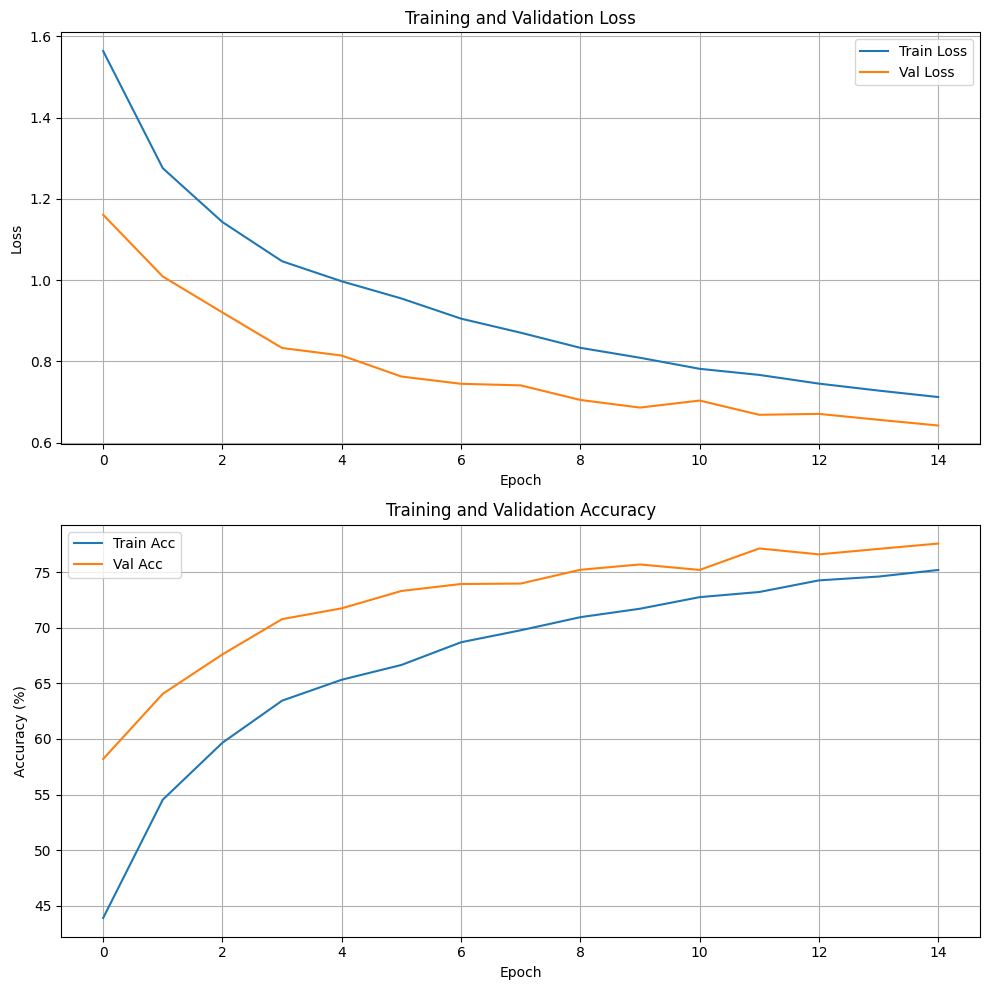

In [18]:
# Plot training history
plot_training_history(history)
plt.show()

In [19]:
### Improve your model and trainning

In [20]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()

        # First convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),
            nn.Dropout2d(0.3)
        )

        # Second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.AvgPool2d(2),
            nn.Dropout2d(0.3)
        )

        # Third convolutional block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.AvgPool2d(2),
            nn.Dropout2d(0.3)
        )

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        # Input shape: [batch, 3, 32, 32]
        x = self.conv1(x)        # -> [batch, 32, 14, 14]
        x = self.conv2(x)        # -> [batch, 64, 7, 7]
        x = self.conv3(x)        # -> [batch, 128, 4, 4]
        x = x.view(-1, 128 * 4 * 4)
        x = self.fc(x)          # -> [batch, 10]
        return x

def create_model2(device):
    # Create model instance
    model = ConvNet2().to(device)

    # Define loss function
    criterion = nn.CrossEntropyLoss().to(device)

    # Define optimizer with improved parameters
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=0.001,
        weight_decay=0.01,
        betas=(0.9, 0.999)
    )

    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=3,
        verbose=True,
        min_lr=1e-6
    )

    return model, criterion, optimizer, scheduler

In [21]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model and training components
model2, criterion2, optimizer2, scheduler2 = create_model2(device)

# Train the model
history2 = train_model(
    model=model2,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion2,
    optimizer=optimizer2,
    device=device,
    scheduler=scheduler2,
    num_epochs=15,
    patience=7
)

Training started...

Epoch 1/15 - Time: 108.00s
Train Loss: 1.6392 - Train Acc: 40.82%
Val Loss: 1.2481 - Val Acc: 54.32%
Learning Rate: 0.001000
------------------------------------------------------------
Validation loss decreased (inf --> 1.248128). Saving model ...

Epoch 2/15 - Time: 105.90s
Train Loss: 1.3424 - Train Acc: 51.73%
Val Loss: 1.0836 - Val Acc: 61.29%
Learning Rate: 0.001000
------------------------------------------------------------
Validation loss decreased (1.248128 --> 1.083574). Saving model ...

Epoch 3/15 - Time: 107.14s
Train Loss: 1.2076 - Train Acc: 57.01%
Val Loss: 0.9671 - Val Acc: 66.44%
Learning Rate: 0.001000
------------------------------------------------------------
Validation loss decreased (1.083574 --> 0.967135). Saving model ...

Epoch 4/15 - Time: 107.52s
Train Loss: 1.1240 - Train Acc: 60.50%
Val Loss: 0.8727 - Val Acc: 69.16%
Learning Rate: 0.001000
------------------------------------------------------------
Validation loss decreased (0.9671

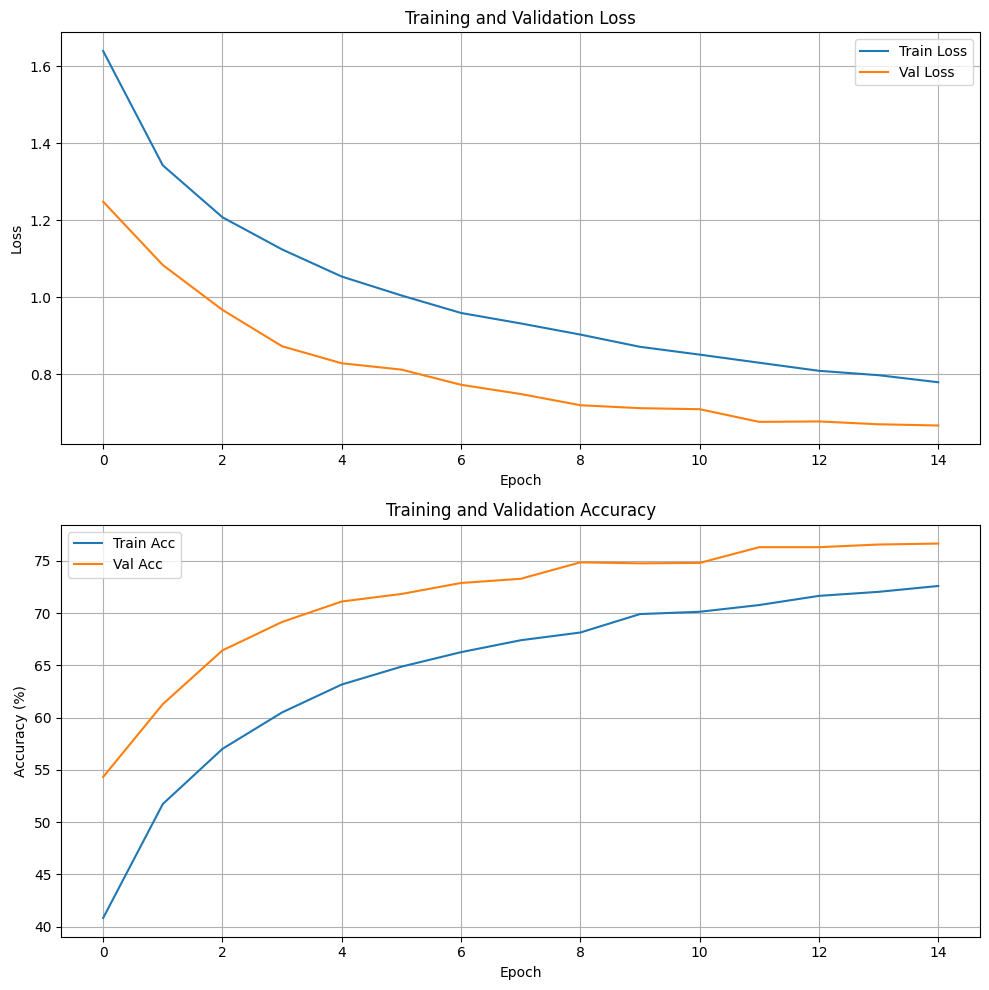

In [22]:
# Plot training history
plot_training_history(history2)
plt.show()

In [ ]:
### Use Transfer Learning

### Generating Submission File

In [23]:
X_test = torch.load('X_test.pth')

<ipython-input-23-c9b6f419ac86>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_test = torch.load('X_test.pth')


In [25]:
X_test = torch.load('X_test.pth')

# Scale features
num_samples, nb_layers, height, width = X_test.shape
X_reshaped = X_test.reshape(num_samples, -1)  # Flatten for scaling
scaler = StandardScaler()
X_scaled_flat = scaler.fit_transform(X_reshaped)  # Scale features
X_test_scaled = X_scaled_flat.reshape(num_samples, nb_layers, height, width)  # Reshape with channel dimension

<ipython-input-25-dd61deb04001>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_test = torch.load('X_test.pth')


In [27]:
X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)

In [28]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(X_test_scaled)

In [29]:
_, predicted_labels = torch.max(predictions, dim=1)

In [33]:
submission = pd.DataFrame({
    'index': np.arange(len(X_test)),
    'label': predicted_labels
})

submission.to_csv('submission.csv', index=False, sep=',')
submission.head()

,index,label
0,0,3
1,1,8
2,2,8
3,3,0
4,4,6
